In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

## Beam Search

Beam Search is an old but popular technique for finding the a more optimal solution to sequence generation problems. At first, it seems that the most obvious solution is to take the highest probability at each time step (greedy decoding) but this approach is suboptimal and often leads to poor and incoherent generations from NLP models. Beam Search sets a beam width (B), and considers B possible solutions at each step, the final probability is the product of all the probabilities in the beam. 

I'd highly recommend watching Andrew Ng's [youtube videos](https://www.youtube.com/watch?v=RLWuzLLSIgw) on Beam Search, they are an excellent introduction to the theory behind beam search. The image below is taken from the video where beam search is used for machine translation. 

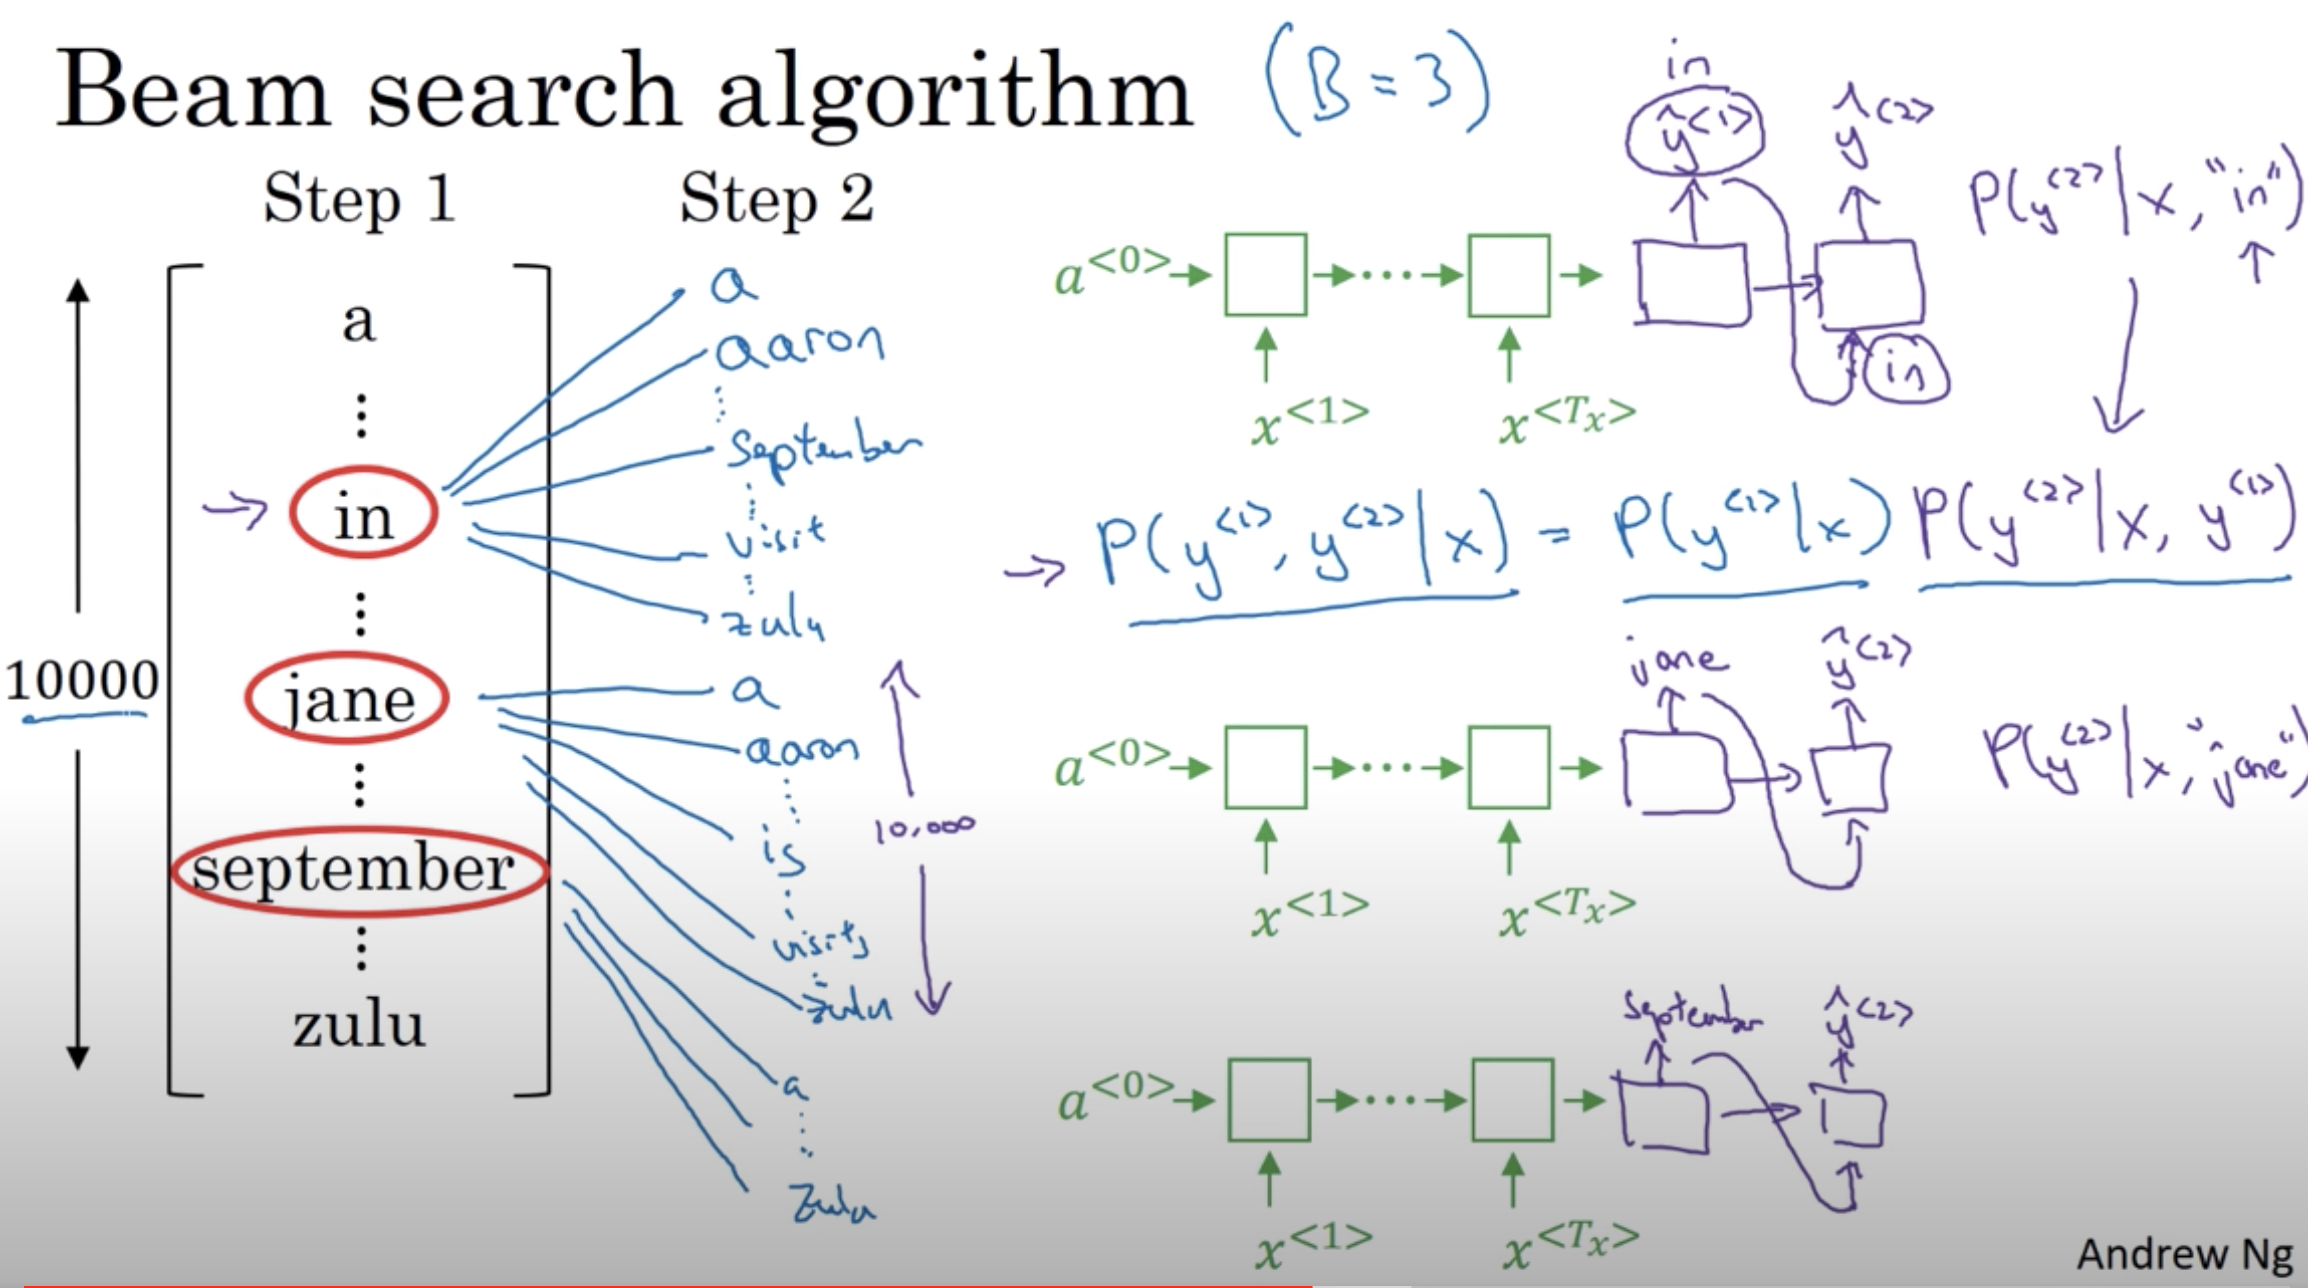

The basic formula for beam search is quite simple and follows this pattern: 

1. At each time step consider the top beam width values.
2. Append the winning values to the current input step.
3. Repeat selection of the top beam width values.
4. Continue iterating until a maximum length or end of sequence token is reached.

Beam search is intuitive, the theory is very straightforward and yet I haven't had much luck finding a satisfying online tutorial and explanation of beam search which is what this blog will hope to serve as. Before diving into an implementation there are a couple of common enhancements to Beam Search which are worth mentioning. 

### Beam Search Enhancements

The first enhancment is simple and that is working with log probabilities instead of probabilities. The reason is that for long sequences, the product of the probabilities becomes very small and in some cases can be prone to numerical underflow. By working with log probabilities we can take the sum of all probabilities, then take the expontial of this sum to get the probability of the sequence. 

For longer sequences, the sum of the log probabilities will also be very negative and so it is common practice to divide the sum of the log probabilities by the length of the sequence, or the lenght of the sequence to power of $\alpha$ where $0 < \alpha <=1$

The output probability for the beam search algorithm then becomes:

$$
\frac{1}{T_y^{\alpha}}\sum_{t=1}^{T_y}P(y^t | x, y^1, ..., y^{t-1})
$$

Next we'll implement our own beam search class and then test it out compared to Greedy decoding by generating some text from GPT2. 

## Implementing Beam Search 

We'll implement our beam search algorithm in PyTorch. While using PyTorch isn't necessary, we could just use numpy, it saves us from casting back and forth between tensors and arrays. First we'll load the necessary libraries, pretrained GPT model and tokenizer from huggingface.Then create our beam search class. 

In [2]:
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import GPT2LMHeadModel, GPT2Tokenizer

language_model = GPT2LMHeadModel.from_pretrained("gpt2-large")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")

time: 22.5 s


Next we'll define our `BeamSearch` class and also two helper classes that wrap `namedtuple` to store the output of the beam and the current beam state. These helper functions make it easier to access different beam properties using dot notation. We could also do this with dictionaries but and access using the standard `dict[key]` notation, it's a matter of preference. 

Our beam search class contains three methods:

1. `length_penalty` which calculates the length normalization penalty as $\frac{1}{T_{y}^{\alpha}}$
2. `get_masked` which will make all probabilities for completed beams. 
    + Completed beams are beams which have predicted an EOS Token. 
3. `step` which completes a single step of the beam search.

Each iteration of the `step` method will find the top B beams, apply the length normalization penalty to the probs, check to see if any beam hypotheses are complete and then return the beam state and beam output.  

In [78]:
################################################################################
class BeamSearch(nn.Module):
    """Beam Search Class."""
    def __init__(self):
        super(BeamSearch, self).__init__()

    def step(self, step: int, logits: torch.tensor, scores=None):
        """
        Decode a single Beam Search step.

        :param step: Index of the current step, starts at 0.
        :param logits: Torch tensor of logits [batch, beam, vocab_size]
        :param scores: Cumulative Scores at each step..
        :return:
        """
        bsz, beam_size, vocab_size = logits.size()

        if step == 0:
            lprobs = logits[:, ::beam_size, :].contiguous()
        else:
            lprobs = logits + scores[:, :, step - 1].unsqueeze(-1)

        next_scores, next_indices = torch.topk(lprobs.view(bsz, -1), k=beam_size*2)

        beams_idx = torch.div(indices_buf, vocab_size)
        next_indices = next_indices.fmod(vocab_size)
        return next_scores, next_indices, beams_idx

time: 4.08 ms


Now that we've defined our beam search class we just need to create a loop to iterate for a desired length. We also need to feed some sort of prompt to gpt. Let's keep it topical and feed the phrase "In early 2020, a new influenza virus" and see what it comes up with. 

We'll also compare to a greedy decode. 


In [118]:
NUM_STEPS = 30
BEAM_SIZE = 5
BATCH_SIZE = 1
input_ids = torch.tensor([tokenizer.encode("""In early 2020, a new influenza virus""")])
input_ids = input_ids.repeat(BEAM_SIZE, 1)

language_model.eval()
beam_search = BeamSearch()
scores = None
scores_buf = torch.zeros(BATCH_SIZE, BEAM_SIZE, NUM_STEPS)
# scores_buf[:, 1:, :] = -1e9

with torch.no_grad():
    for step in range(NUM_STEPS):
        logits = language_model(input_ids)[0]
        logits = logits[:, -1, :].contiguous().unsqueeze(0)

        scores, inds, beams = beam_search.step(step, logits, scores_buf)
        scores_buf[:, :, step] = scores.squeeze()[:BEAM_SIZE]
        input_ids = torch.cat([input_ids[beams[:,:BEAM_SIZE].squeeze(), :], 
                               inds.t()[:BEAM_SIZE, :]], dim=1)
    

time: 22.7 s


In [119]:
tokenizer.decode(input_ids[0, :])

'In early 2020, a new influenza virus is expected to emerge that is highly virulent and highly transmittable to humans. It will likely be the most virulent pandemic in human history'

time: 2.7 ms


### Comparing to a simple greedy decoding algorithm.

In [107]:
input_ids = torch.tensor([tokenizer.encode("""In early 2020, a new influenza virus""")])
beam_search = BeamSearch()

for step in range(NUM_STEPS):
    logits = language_model(input_ids)[0]
    logits = logits[:, -1, :].contiguous()
    output = torch.argmax(logits, dim=-1).unsqueeze(-1)
    input_ids = torch.cat([input_ids, output], dim=1)
    

time: 11 s


In [108]:
tokenizer.decode(input_ids[0, :])

'In early 2020, a new influenza virus will be released into the wild. The virus will be similar to the H5N1 virus that caused the 2009 pandemic, but it will be'

time: 6.73 ms


## A quick comparison to the built-in generate method from huggingface. 

### Greedy Decoding

In [ ]:
# encode context the generation is conditioned on
input_ids = torch.tensor([tokenizer.encode('In early 2020, a new influenza virus')])

# generate text until the output length (which includes the context length) reaches 50
greedy_output = language_model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

### Beam Search 

In [120]:
# set return_num_sequences > 1
beam_outputs = language_model.generate(
    input_ids, 
    max_length=28, 
    num_beams=5, 
    num_return_sequences=3
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
    print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


UnboundLocalError: local variable 'next_tokens' referenced before assignment

time: 38.8 ms
